<a href="https://colab.research.google.com/github/Mark-yank/Trabalho_Computacao_Grafica/blob/main/Computa%C3%A7%C3%A3o_Gr%C3%A1fica_2025_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Versão FINAL



```
# Isto está formatado como código
```

### BIBLIOTECAS

In [ ]:
#Definidos as bibliotecas que estão sendo utilizadas.
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

### FUNÇÃO DE CRIAÇÃO DE SÓLIDOS

In [ ]:
#Função definindo os pontos do paralelepipedo
def create_closed_box_edges(base, comprimento, altura, origem=[0, 0, 0]):
    ox, oy, oz = origem
    half_base = base / 2
    half_comprimento = comprimento / 2
    #Cria a lista de vertices do solido
    vertices = np.array([
        [ox - half_base, oy - half_comprimento, oz],           # V0
        [ox + half_base, oy - half_comprimento, oz],           # V1
        [ox + half_base, oy + half_comprimento, oz],           # V2
        [ox - half_base, oy + half_comprimento, oz],           # V3
        [ox - half_base, oy - half_comprimento, oz + altura],  # V4
        [ox + half_base, oy - half_comprimento, oz + altura],  # V5
        [ox + half_base, oy + half_comprimento, oz + altura],  # V6
        [ox - half_base, oy + half_comprimento, oz + altura],  # V7
    ])

    # Cada face quadrada é dividida em dois triângulos para criar a malha triangularizada
    faces = [
        [0, 1, 2], [0, 2, 3],  # base
        [4, 5, 6], [4, 6, 7],  # topo
        [0, 1, 5], [0, 5, 4],  # traseira
        [1, 2, 6], [1, 6, 5],  # direita
        [2, 3, 7], [2, 7, 6],  # frente
        [3, 0, 4], [3, 4, 7],  # esquerda
    ]
    return vertices, faces

#Função que define os parametros da curva de hermite
def hermite(p0, t0, p1, t1, num_points):
    t = np.linspace(0, 1, num_points)
    h00 = 2 * t**3 - 3 * t**2 + 1
    h10 = t**3 - 2 * t**2 + t
    h01 = -2 * t**3 + 3 * t**2
    h11 = t**3 - t**2
    return (h00[:, None] * p0 + h10[:, None] * t0 +
            h01[:, None] * p1 + h11[:, None] * t1)

#Função que gera os vertices e faces do cano curvado
def generate_cano_com_espessura_hermite(p0, p1, t0, t1, outer_radius, thickness, num_points=10, num_circle_points=10):
    inner_radius = outer_radius - thickness
    curve_points = hermite(p0, t0, p1, t1, num_points)
    outer_rings = []
    inner_rings = []

    theta = np.linspace(0, 2 * np.pi, num_circle_points, endpoint=False)

    for i in range(len(curve_points) - 1):
        center = curve_points[i]
        next_center = curve_points[i + 1]

        direction = next_center - center
        direction = direction / np.linalg.norm(direction)

        # Geração da base ortonormal
        a = np.array([1, 0, 0])
        if np.allclose(direction, a):
            a = np.array([0, 1, 0])
        b = np.cross(direction, a)
        b = b / np.linalg.norm(b)
        a = np.cross(b, direction)

        # Gera círculo externo e interno
        def make_ring(radius):
            return [center + radius * (np.cos(angle) * a + np.sin(angle) * b) for angle in theta]

        outer_rings.append(np.array(make_ring(outer_radius)))
        inner_rings.append(np.array(make_ring(inner_radius)))
    vertices,faces = triangulate_espessura_cano(outer_rings, inner_rings)
    return vertices,faces

#Função que cria as faces e vertices do cano externo e interno conectando-los
def triangulate_espessura_cano(outer_rings, inner_rings):

    i=1
    vertices = np.vstack(outer_rings + inner_rings)
    faces = []
    n = len(outer_rings)
    m = len(outer_rings[0])

    # Superfície externa
    for i in range(n - 1):
        for j in range(m):
            p0 = i * m + j
            p1 = i * m + (j + 1) % m
            p2 = (i + 1) * m + j
            p3 = (i + 1) * m + (j + 1) % m
            faces.append([p0, p1, p2])
            faces.append([p1, p3, p2])

    # Superfície interna
    offset = n * m
    for i in range(n - 1):
        for j in range(m):
            p0 = offset + i * m + j
            p1 = offset + i * m + (j + 1) % m
            p2 = offset + (i + 1) * m + j
            p3 = offset + (i + 1) * m + (j + 1) % m
            faces.append([p0, p2, p1])  # ordem invertida
            faces.append([p1, p2, p3])

    # Conexões nas extremidades
    for j in range(m):
        # Boca inicial
        o0 = j
        o1 = (j + 1) % m
        i0 = offset + j
        i1 = offset + (j + 1) % m
        faces.append([o0, i1, i0])
        faces.append([o0, o1, i1])

        # Boca final
        o0 = (n - 1) * m + j
        o1 = (n - 1) * m + (j + 1) % m
        i0 = offset + (n - 1) * m + j
        i1 = offset + (n - 1) * m + (j + 1) % m
        faces.append([o0, i0, i1])
        faces.append([o0, i1, o1])

    return vertices, faces

#Função que gera os vertices e faces do cano reto
def generate_cano_com_espessura(p0, p1, outer_radius, thickness, num_points=10, num_circle_points=10):

    inner_radius = outer_radius - thickness
    t = np.linspace(0, 1, num_points)
    centers = (1 - t)[:, None] * p0 + t[:, None] * p1
    theta = np.linspace(0, 2 * np.pi, num_circle_points, endpoint=False)

    direction = p1 - p0
    direction = direction / np.linalg.norm(direction)
    a = np.array([1, 0, 0])
    if np.allclose(direction, a):
        a = np.array([0, 1, 0])
    b = np.cross(direction, a)
    b = b / np.linalg.norm(b)
    a = np.cross(b, direction)

    def generate_ring(center, radius):
        return [center + radius * (np.cos(angle) * a + np.sin(angle) * b) for angle in theta]

    outer_rings = [np.array(generate_ring(center, outer_radius)) for center in centers]
    inner_rings = [np.array(generate_ring(center, inner_radius)) for center in centers]

    vertices, faces = triangulate_cano_com_espessura(outer_rings, inner_rings)
    return vertices,faces

#Função que cria as faces e vertices do cano externo e interno conectando-los
def triangulate_cano_com_espessura(outer_rings, inner_rings):
    """
    Gera os triângulos das paredes do cano com espessura.
    """
    i=2
    vertices = np.vstack(outer_rings + inner_rings)
    faces = []
    n = len(outer_rings)
    m = len(outer_rings[0])  # num_circle_points

    # Lados externos
    for i in range(n - 1):
        for j in range(m):
            p0 = i * m + j
            p1 = i * m + (j + 1) % m
            p2 = (i + 1) * m + j
            p3 = (i + 1) * m + (j + 1) % m
            faces.append([p0, p1, p2])
            faces.append([p1, p3, p2])

    # Lados internos
    offset = n * m
    for i in range(n - 1):
        for j in range(m):
            p0 = offset + i * m + j
            p1 = offset + i * m + (j + 1) % m
            p2 = offset + (i + 1) * m + j
            p3 = offset + (i + 1) * m + (j + 1) % m
            # Inversão da ordem para manter normais corretas
            faces.append([p0, p2, p1])
            faces.append([p1, p2, p3])

    # Conexões entre anéis (boca da frente e de trás)
    for i in range(m):
        # Boca inicial
        o0 = i
        o1 = (i + 1) % m
        i0 = offset + i
        i1 = offset + (i + 1) % m
        faces.append([o0, i1, i0])
        faces.append([o0, o1, i1])

        # Boca final
        o0 = (n - 1) * m + i
        o1 = (n - 1) * m + (i + 1) % m
        i0 = offset + (n - 1) * m + i
        i1 = offset + (n - 1) * m + (i + 1) % m
        faces.append([o0, i0, i1])
        faces.append([o0, i1, o1])

    return vertices, faces

#Função que gera os vertices e faces do cilindro fechado
def generate_cilindro_fechado(p0, p1, radius, num_points=10, num_circle_points=10):
    t = np.linspace(0, 1, num_points)
    axis_points = (1 - t)[:, None] * p0 + t[:, None] * p1
    circle_points_list = []

    theta = np.linspace(0, 2 * np.pi, num_circle_points, endpoint=False)

    direction = p1 - p0
    direction = direction / np.linalg.norm(direction)

    # Base ortonormal do círculo
    a = np.array([1, 0, 0])
    if np.allclose(direction, a):
        a = np.array([0, 1, 0])
    b = np.cross(direction, a)
    b = b / np.linalg.norm(b)
    a = np.cross(b, direction)

    for center in axis_points:
        circle_points = []
        for angle in theta:
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            point = center + x * a + y * b
            circle_points.append(point)
        circle_points_list.append(np.array(circle_points))

    base_center = axis_points[0]
    top_center = axis_points[-1]
    base_circle = circle_points_list[0]
    top_circle = circle_points_list[-1]

    vertices,faces = triangulate_cilindro_fechado(axis_points,circle_points_list,base_center,top_center,base_circle,top_circle)
    return vertices,faces

#Função que conecta os vertices e as faces das circuferencias do cilindro, fazendo as laterais, topo e base
def triangulate_cilindro_fechado(axis_points,circle_points_list,base_center,top_center,base_circle,top_circle):

    n_rings = len(circle_points_list)
    m = len(circle_points_list[0])  # pontos por círculo

    # Junta todos os vértices em um único array
    vertices = np.vstack(circle_points_list + [base_center, top_center])
    base_center_index = len(vertices) - 2
    top_center_index = len(vertices) - 1

    faces = []

    # Faces laterais (entre anéis)
    for i in range(n_rings - 1):
        for j in range(m):
            p0 = i * m + j
            p1 = i * m + (j + 1) % m
            p2 = (i + 1) * m + j
            p3 = (i + 1) * m + (j + 1) % m
            faces.append([p0, p1, p2])
            faces.append([p1, p3, p2])

    # Tampa inferior (base)
    for j in range(m):
        v0 = base_center_index
        v1 = j
        v2 = (j + 1) % m
        faces.append([v0, v1, v2])

    # Tampa superior (topo)
    offset = (n_rings - 1) * m
    for j in range(m):
        v0 = top_center_index
        v1 = offset + (j + 1) % m
        v2 = offset + j
        faces.append([v0, v1, v2])  # sentido horário invertido

    return vertices, faces

#Função que gera os vertices da reta
def criar_reta(P1, P2):
    i=4
    distancia = np.linalg.norm(P2 - P1)
    # Vetor direção (qualquer direção que você quiser)
    if distancia != 4:
        direcao = P2 - P1
        # Normaliza o vetor (comprimento vira 1)
        direcao_unitaria = direcao / np.linalg.norm(direcao)
        # Escala o vetor para comprimento 4
        direcao_reta = direcao_unitaria * 4
    P2 = P1+direcao_reta
    vertices = np.array([P1, P2])
    return vertices

### FUNÇÕES PLOT

In [ ]:
#Defini as cores que os solidos podem possuir
cores = ['black','red','green','blue','purple']

#Definir o plot das faces tringulares dos poligonos
def plot_wireframe_g(vertices, faces,i):
    added_edges = set()

    for tri in faces:
        for a, b in [(0, 1), (1, 2), (2, 0)]:
            idx1, idx2 = tri[a], tri[b]
            edge = tuple(sorted((idx1, idx2)))
            if edge in added_edges:
                continue
            added_edges.add(edge)

            x = [vertices[idx1][0], vertices[idx2][0], None]
            y = [vertices[idx1][1], vertices[idx2][1], None]
            z = [vertices[idx1][2], vertices[idx2][2], None]

            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='lines',
                line=dict(color=cores[i], width=2),
                showlegend=False
            ))


# Plot da reta no sistema 3D
def plot_wireframe_reta(vertices_reta, i):
    P1 = vertices_reta[0]
    P2 = vertices_reta[1]
    x_vals = [P1[0], P2[0]]
    y_vals = [P1[1], P2[1]]
    z_vals = [P1[2], P2[2]]

    fig.add_trace(go.Scatter3d(
        x=x_vals, y=y_vals, z=z_vals,
        mode='lines+markers',
        line=dict(color=cores[i], width=4),
        marker=dict(size=4),
        showlegend=False
    ))

### FUNÇÃO DA CAMERA

In [ ]:
#camera
#Normaliza as arestas que conecta os vertices
def normalize(v):
    norm = np.linalg.norm(v)
    return v / norm if norm > 0 else v

#Cria a matriz da camera, sendo uma combinação da matriz de rotação e translação
def view_matrix(eye, target, up):
    f = normalize(np.array(target) - np.array(eye))   # direção da câmera
    r = normalize(np.cross(f, up))                    # eixo X da câmera
    u = np.cross(r, f)                                # eixo Y real da câmera

    # Matriz de rotação (invertida, pois transformamos o mundo)
    rotation = np.array([
        [ r[0],  r[1],  r[2], 0],
        [ u[0],  u[1],  u[2], 0],
        [-f[0], -f[1], -f[2], 0],
        [  0,     0,     0,   1]
    ])

    # Matriz de translação inversa
    translation = np.array([
        [1, 0, 0, -eye[0]],
        [0, 1, 0, -eye[1]],
        [0, 0, 1, -eye[2]],
        [0, 0, 0,    1   ]
    ])

    view = rotation @ translation
    return view

#multiplica as matrizes de vertices dos nosso solidos com a matriz resultante da camera
def transformar_vertices_com_view(vertices, view_matrix):
    n = vertices.shape[0]
    vertices_homog = np.hstack([vertices, np.ones((n, 1))])  # Converte para coordenadas homogêneas
    transformed = (view_matrix @ vertices_homog.T).T
    return transformed[:, :3]  # Remove coordenada homogênea


### FUNÇÕES DE TRANSFORMAÇÃO

In [ ]:
#Define a matriz de escala a partir dos valores sx,sy,sz
def criar_matriz_escala(sx, sy, sz):
    matriz_escala = np.array([
        [sx, 0, 0, 0],
        [0, sy, 0, 0],
        [0, 0, sz, 0],
        [0, 0, 0, 1]
    ])
    return matriz_escala

#Define matriz de rotação dos solidos com eixo x fixo
def criar_matriz_rotacao_x(angulo_rad):
    c = np.cos(angulo_rad)
    s = np.sin(angulo_rad)
    matriz_rotacaox= np.array([
        [1, 0, 0, 0],
        [0, c, -s, 0],
        [0, s, c, 0],
        [0, 0, 0, 1]
    ])
    return matriz_rotacaox

#Define matriz de rotação da reta com eixo x fixo
def criar_matriz_rotacaor_x(vertices,angulo_rad):
    P0=vertices[0]
    P1=vertices[1]
    v=P1-P0
    c = np.cos(angulo_rad)
    s = np.sin(angulo_rad)
    matriz_rotacaox= np.array([
        [1, 0, 0, 0],
        [0, c, -s, 0],
        [0, s, c, 0],
        [0, 0, 0, 1]
    ])
    v_rot = matriz_rotacaox @ v.T
    P1_rot = P0 + v_rot
    vertices_rotacaox = np.array([P0, P1_rot])
    return vertices_rotacaox

#Define matriz de rotação dos solidos com eixo y fixo
def criar_matriz_rotacao_y(angulo_rad):
    c = np.cos(angulo_rad)
    s = np.sin(angulo_rad)
    matriz_rotacaoy=np.array([
        [c, 0, s, 0],
        [0, 1, 0, 0],
        [-s, 0, c, 0],
        [0, 0, 0, 1]
    ])
    return matriz_rotacaoy

#Define matriz de rotação da reta com eixo y fixo
def criar_matriz_rotacaor_y(vertices,angulo_rad):
    P0=vertices[0]
    P1=vertices[1]
    v=P1-P0
    c = np.cos(angulo_rad)
    s = np.sin(angulo_rad)
    matriz_rotacaoy=np.array([
        [c, 0, s, 0],
        [0, 1, 0, 0],
        [-s, 0, c, 0],
        [0, 0, 0, 1]
    ])
    v_rot = matriz_rotacaoy @ v.T
    P1_rot = P0 + v_rot
    vertices_rotacaoy = np.array([P0, P1_rot])
    return vertices_rotacaoy

#Define matriz de rotação dos solidos com eixo z fixo
def criar_matriz_rotacao_z(angulo_rad):
    c = np.cos(angulo_rad)
    s = np.sin(angulo_rad)
    matriz_rotacaoz = np.array([
        [c, -s, 0, 0],
        [s, c, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    return matriz_rotacaoz

#Define matriz de rotação da reta com eixo z fixo
def criar_matriz_rotacaor_z(vertices,angulo_rad):
    P0=vertices[0]
    P1=vertices[1]
    v=P1-P0
    c = np.cos(angulo_rad)
    s = np.sin(angulo_rad)
    matriz_rotacaoz = np.array([
        [c, -s, 0, 0],
        [s, c, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    v_rot = matriz_rotacaoz @ v.T
    P1_rot = P0 + v_rot
    vertices_rotacaoz = np.array([P0, P1_rot])
    return vertices_rotacaoz

#Define matriz de translação dos solidos com base os valores de tx,ty,tz
def criar_matriz_translacao(tx, ty, tz):
    matriz_translacao = np.array([
        [1, 0, 0, tx],
        [0, 1, 0, ty],
        [0, 0, 1, tz],
        [0, 0, 0, 1]
    ])
    return matriz_translacao

#Função que chama as funções de transformações anteriores e aplica na nossa matriz de vertices dos objetos
def matriz_resultante(vertices,escala,ang_rotacao,translacao):
    #Centroide, usado para translatar o objeto para a origem independente de onde ele esteja
    centroide = np.mean(vertices, axis=0)

    #Translada para a origem
    vertices_transladados = vertices - centroide

    #Chamando as matrizes de transformações
    escala_x, escala_y, escala_z = escala
    angulo_rotacao_x, angulo_rotacao_y, angulo_rotacao_z = ang_rotacao
    tx, ty, tz = translacao
    matriz_translacao = criar_matriz_translacao(tx, ty, tz)
    matriz_rotacaox = criar_matriz_rotacao_x(angulo_rotacao_x)
    matriz_rotacaoy = criar_matriz_rotacao_y(angulo_rotacao_y)
    matriz_rotacaoz = criar_matriz_rotacao_z(angulo_rotacao_z)
    matriz_escala = criar_matriz_escala(escala_x, escala_y, escala_z)

    # Adiciona a coordenada homogênea (1) aos vértices
    vertices_homogeneos = np.hstack((vertices_transladados, np.ones((vertices.shape[0], 1))))

    # Aplica as transformações: Escala -> Rotação -> Translação
    matriz_transformacao_combinada = matriz_translacao @ matriz_rotacaox @ matriz_rotacaoy @ matriz_rotacaoz @ matriz_escala

    vertices_transformados_homogeneos = (matriz_transformacao_combinada @ vertices_homogeneos.T).T

    # Remove a coordenada homogênea
    vertices_transformados = vertices_transformados_homogeneos[:, :3]

    # 3. Translada de volta para o local original (relativo ao centroide original)
    vertices_final = vertices_transformados + centroide

    return vertices_final

### PARAMETROS

In [ ]:
#Parametros de origem das figuras e das transformações aplicadas

#paralelepipedo
base_paralelepipedo=4
comprimento_paralelepipedo=6
altura_paralelepipedo=3
escala_para = (0.5, 0.5, 0.5)
ang_rotacao_para = (90, 90, 0)
translacao_para = (0, 0, -3)

#cano_curvado
p0_canoc = np.array([2, 2, 0])
p1_canoc = np.array([5, 2, 7])
t0_canoc = np.array([5, 0, 8])
t1_canoc = np.array([0, 5, -8])
num_points=10
num_circle_points=10
raio_ext_canoc = 1.0
espessura_canoc = 0.2
escala_canoc = (0.5, 0.5, 0.5)
ang_rotacao_canoc = (0, 45, 0)
translacao_canoc = (4, 4, 4)

#cano_reto
p0_canor = np.array([4, 4, -3])
p1_canor = np.array([9, 9, -3])
raio_ext_canor = 1.0
espessura_canor = 0.2
num_points=10
num_circle_points=10
escala_canor = (0.6, 0.6, 0.5)
ang_rotacao_canor = (90, 0, 0)
translacao_canor = (0, 0, 0)

#Definindo cilindro
p0_cilindro = np.array([5, -10, 5])
p1_cilindro = np.array([5, 0, 5])
raio_cilindro = 2.0
escala_cilindro = (0.5, 0.5, 0.6)
ang_rotacao_cilindro = (0, 0, 45)
translacao_cilindro = (-2, 0, 1)

#Definindo Reta tamanho 4
P1_reta = np.array([9, 0, 0])
P2_reta = np.array([-1, 1, 0])
escala_reta = (1, 1, 1)
ang_rotacao_reta = (0, 90, 0)
translacao_reta = (0, 0, 0)

# Parâmetros da câmera
eye = (5, 5, 0)
target = (0, 0, 0)
up = (0, 0, 1)

### GERA MATRIZES DAS FIGURAS

In [ ]:
#Definindo as listas de vertices e faces das figuras para podemos plotar os objetos
#Definindo apenas a criação dos objetos puros
vertices_para, faces_para = create_closed_box_edges(base_paralelepipedo, comprimento_paralelepipedo, altura_paralelepipedo)
vertices_canoc, faces_canoc = generate_cano_com_espessura_hermite(p0_canoc, p1_canoc, t0_canoc, t1_canoc, raio_ext_canoc, espessura_canoc)
vertices_canor, faces_canor = generate_cano_com_espessura(p0_canor, p1_canor, raio_ext_canor, espessura_canor)
vertices_cilindro,faces_cilindro = generate_cilindro_fechado(p0_cilindro, p1_cilindro, raio_cilindro)
vertices_reta = criar_reta(P1_reta, P2_reta)

#Aplicando as transformações nos objetos recem criados
vertices_para_transformada = matriz_resultante(vertices_para,escala_para,ang_rotacao_para,translacao_para)
vertices_canoc_transformada = matriz_resultante(vertices_canoc,escala_canoc, ang_rotacao_canoc,translacao_canoc)
vertices_canor_transformada = matriz_resultante(vertices_canor,escala_canor, ang_rotacao_canor,translacao_canor)
vertices_cilindro_transformada = matriz_resultante(vertices_cilindro,escala_cilindro, ang_rotacao_cilindro,translacao_cilindro)
vertices_reta_transformada = matriz_resultante(vertices_reta,escala_reta, ang_rotacao_reta,translacao_reta)


# Define a matriz resultante do sistema de coordenada da camera
view = view_matrix(eye, target, up)

# Aplica a transformação da câmera aos vértices dos objetos
vertices_view_para = transformar_vertices_com_view(vertices_para_transformada , view)
vertices_view_canoc = transformar_vertices_com_view(vertices_canoc_transformada , view)
vertices_view_cilindro = transformar_vertices_com_view(vertices_cilindro_transformada , view)
vertices_view_canor = transformar_vertices_com_view(vertices_canor_transformada , view)
vertices_view_reta = transformar_vertices_com_view(vertices_reta_transformada, view)

### MAIN

In [ ]:
#Main da parte de plotagem, mostra os objetos individuais, os objetos no sistema do mundo e os objetos no sistema da camera
fig = go.Figure()
#Define o nome das plotagens
nomes_plot = ["Paralelepipedo","Cano curvo","Cano reto", "Cilindro","Reta", "Mundo", "Sistema da câmera"]
#Recebe uma entrada do teclado para o usuário escolher qual sistema plotar
função_ent = input("1-plotar figuras individuais; 2-plotar mundo; 3-plotar camera: ")

if função_ent == '1':
    #Recebe uma entrada do teclado para o usuário escolher qual objeto plotar
    poligono = input("1-paralelepipedo; 2-cano curvado; 3-cano reto; 4-cilindro; 5-reta: ")
    if poligono == '1':
        plot_wireframe_g(vertices_para_transformada, faces_para, i=3)
        n_plot=0
    elif poligono == '2':
        plot_wireframe_g(vertices_canoc_transformada, faces_canoc, i=1)
        n_plot=1
    elif poligono == '3':
        plot_wireframe_g(vertices_canor_transformada, faces_canor, i=0)
        n_plot=2
    elif poligono == '4':
        plot_wireframe_g(vertices_cilindro_transformada, faces_cilindro, i=2)
        n_plot=3
    elif poligono == '5':
        plot_wireframe_reta(vertices_reta_transformada, i=4)
        n_plot=4


elif função_ent == '2':
    # Plota os objetos no sistema do mundo
    plot_wireframe_g(vertices_para_transformada, faces_para, i=0)
    plot_wireframe_g(vertices_canoc_transformada, faces_canoc, i=1)
    plot_wireframe_g(vertices_cilindro_transformada, faces_cilindro, i=2)
    plot_wireframe_g(vertices_canor_transformada, faces_canor, i=3)
    plot_wireframe_reta(vertices_reta_transformada, i=4)
    n_plot=5

elif função_ent == '3':
    # Plota os objetos no sistema da câmera
    plot_wireframe_g(vertices_view_canor, faces_canor, i=0)
    plot_wireframe_g(vertices_view_canoc, faces_canoc, i=1)
    plot_wireframe_g(vertices_view_cilindro, faces_cilindro, i=2)
    plot_wireframe_g(vertices_view_para, faces_para, i=3)
    plot_wireframe_reta(vertices_view_reta, i=4)
    n_plot=6

# Atualiza layout como no original
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-10, 10]),
        yaxis=dict(range=[-10, 10]),
        zaxis=dict(range=[-10, 10]),
    aspectmode='manual',
    aspectratio=dict(x=1, y=1, z=1)),
    title=nomes_plot[n_plot],
    showlegend=False
)

fig.show()

1-plotar figuras individuais; 2-plotar mundo; 3-plotar camera: 1
1-paralelepipedo; 2-cano curvado; 3-cano reto; 4-cilindro; 5-reta: 2


### PERSPECTIVA DE CENA(VERTICES)

In [ ]:
#Cria um sistema 3D pare representar a projeção em perspectiva da cena (essa função gera a projeção de todos os objetos, mesmo aqueles fora do espaço de projeção)
def perspective_projection_matrix(fov_y_deg, aspect_ratio, near, far):
    fov_y_rad = np.radians(fov_y_deg)
    f = 1.0 / np.tan(fov_y_rad / 2.0)

    projection_matrix = np.array([
        [f / aspect_ratio, 0,                0,                                 0],
        [0,                f,                0,                                 0],
        [0,                0, (far + near) / (near - far), (2 * far * near) / (near - far)],
        [0,                0,               -1,                                 0]
    ])
    return projection_matrix

#Aplica a matriz de projeção feita anteriormente nos nossos objetos
def aplicar_projecao_perspectiva(vertices_camera, matriz_projecao):
    n = vertices_camera.shape[0]
    vertices_camera_homog = np.hstack([vertices_camera, np.ones((n, 1))])

    vertices_projetados_homog = (matriz_projecao @ vertices_camera_homog.T).T

    # Realiza a divisão de perspectiva (divisão por W)
    # Evita divisão por zero caso algum vértice tenha W=0 (vários casos, como na origem)
    w = vertices_projetados_homog[:, 3].copy() # Cópia para evitar modificação durante a divisão
    # se w for 0, iremos subsituir para um numero muito baixo para evitar divisão por 0
    w[w == 0] = 1e-8
    vertices_projetados_ndc = vertices_projetados_homog[:, :3] / w[:, None]


    # Agora vertices_projetados_ndc está no espaço de dispositivo normalizado (NDC), que varia de -1 a 1
    return vertices_projetados_ndc

# Parâmetros da projeção
fov_y_deg = 45  # Campo de visão em Y em graus
aspect_ratio = 1  # Assumindo um viewport quadrado por simplicidade (width / height)
near = 1.0      # Plano near
far = 100.0     # Plano far

# Cria a matriz de projeção
matriz_projecao_persp = perspective_projection_matrix(fov_y_deg, aspect_ratio, near, far)

vertices_projetados_ndc_para = aplicar_projecao_perspectiva(vertices_view_para, matriz_projecao_persp)
vertices_projetados_ndc_canoc = aplicar_projecao_perspectiva(vertices_view_canoc, matriz_projecao_persp)
vertices_projetados_ndc_canor = aplicar_projecao_perspectiva(vertices_view_canor, matriz_projecao_persp)
vertices_projetados_ndc_cilindro = aplicar_projecao_perspectiva(vertices_view_cilindro, matriz_projecao_persp)
vertices_projetados_ndc_reta = aplicar_projecao_perspectiva(vertices_view_reta, matriz_projecao_persp)

fig_projecao = go.Figure()
nomes_plot_projecao = "Objetos Projetados (NDC)"

fig_projecao.add_trace(go.Scatter3d(
    x=vertices_projetados_ndc_canor[:, 0], y=vertices_projetados_ndc_canor[:, 1], z=vertices_projetados_ndc_canor[:, 2],
    mode='markers', marker=dict(color=cores[0], size=3), name='Cano Reto (NDC)'
))
fig_projecao.add_trace(go.Scatter3d(
    x=vertices_projetados_ndc_canoc[:, 0], y=vertices_projetados_ndc_canoc[:, 1], z=vertices_projetados_ndc_canoc[:, 2],
    mode='markers', marker=dict(color=cores[1], size=3), name='Cano Curvo (NDC)'
))
fig_projecao.add_trace(go.Scatter3d(
    x=vertices_projetados_ndc_cilindro[:, 0], y=vertices_projetados_ndc_cilindro[:, 1], z=vertices_projetados_ndc_cilindro[:, 2],
    mode='markers', marker=dict(color=cores[2], size=3), name='Cilindro (NDC)'
))
fig_projecao.add_trace(go.Scatter3d(
    x=vertices_projetados_ndc_para[:, 0], y=vertices_projetados_ndc_para[:, 1], z=vertices_projetados_ndc_para[:, 2],
    mode='markers', marker=dict(color=cores[3], size=3), name='Paralelepípedo (NDC)'
))
fig_projecao.add_trace(go.Scatter3d(
    x=vertices_projetados_ndc_reta[:, 0], y=vertices_projetados_ndc_reta[:, 1], z=vertices_projetados_ndc_reta[:, 2],
    mode='markers', marker=dict(color=cores[4], size=3), name='Reta (NDC)'
))


fig_projecao.update_layout(
    scene=dict(
        xaxis=dict(range=[-10, 10], title='X (NDC)'),
        yaxis=dict(range=[-10, 10], title='Y (NDC)'),
        zaxis=dict(range=[-10, 10], title='Z (NDC)'),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title=nomes_plot_projecao,
    showlegend=True
)

fig_projecao.show()

### PROJEÇÃO EM PERSPECTIVA(ARESTAS)

In [ ]:
#Com a projeção em perspectiva anterior sendo feita apenas com base nos vertices, aplicaremos uma projeção baseada em arestas
def gerar_arestas_de_faces(faces):
    arestas = set()
    for face in faces:
        v0, v1, v2 = face
        arestas.add(tuple(sorted((v0, v1))))
        arestas.add(tuple(sorted((v1, v2))))
        arestas.add(tuple(sorted((v2, v0))))
    return list(arestas)

arestas_para = gerar_arestas_de_faces(faces_para)
arestas_canor = gerar_arestas_de_faces(faces_canor)
arestas_canoc = gerar_arestas_de_faces(faces_canoc)
arestas_cilindro = gerar_arestas_de_faces(faces_cilindro)

vertices_projetados_ndc_para = aplicar_projecao_perspectiva(vertices_view_para, matriz_projecao_persp)
vertices_projetados_ndc_canor =aplicar_projecao_perspectiva(vertices_view_canor, matriz_projecao_persp)
vertices_projetados_ndc_canoc = aplicar_projecao_perspectiva(vertices_view_canoc, matriz_projecao_persp)
vertices_projetados_ndc_cilindro = aplicar_projecao_perspectiva(vertices_view_cilindro, matriz_projecao_persp)
vertices_projetados_ndc_reta = aplicar_projecao_perspectiva(vertices_view_reta, matriz_projecao_persp)

fig_projecao = go.Figure()
nomes_plot_projecao = "Objetos Projetados em Wireframe (NDC)"
def adicionar_arestas_ao_plot(fig, vertices_proj, arestas, cor, nome):
    for i, aresta in enumerate(arestas):
      # Pega os índices dos dois vértices da aresta
      v1_idx, v2_idx = aresta
      # Pega as coordenadas X, Y, Z dos vértices projetados
      x_coords = [vertices_proj[v1_idx, 0], vertices_proj[v2_idx, 0]]
      y_coords = [vertices_proj[v1_idx, 1], vertices_proj[v2_idx, 1]]
      z_coords = [vertices_proj[v1_idx, 2], vertices_proj[v2_idx, 2]]

      fig.add_trace(go.Scatter3d(
          x=x_coords, y=y_coords, z=z_coords,
          mode='lines',
          line=dict(color=cor, width=4),
          showlegend=(i == 0),
          name=nome
          ))
def adicionar_reta_ao_plot(fig, vertices_proj, cor, nome):
      x_coords = [vertices_proj[0, 0], vertices_proj[1, 0]]
      y_coords = [vertices_proj[0, 1], vertices_proj[1, 1]]
      z_coords = [vertices_proj[0, 2], vertices_proj[1, 2]]

      fig.add_trace(go.Scatter3d(
          x=x_coords, y=y_coords, z=z_coords,
          mode='lines',
          line=dict(color=cor, width=4),
          showlegend=True,
          name=nome
          ))

# Adiciona o paralelepípedo ao plot usando as arestas
adicionar_arestas_ao_plot(fig_projecao, vertices_projetados_ndc_para, arestas_para, cores[3], 'Paralelepípedo (NDC)')
adicionar_arestas_ao_plot(fig_projecao, vertices_projetados_ndc_canor, arestas_canor, cores[0], 'Cano Reto (NDC)')
adicionar_arestas_ao_plot(fig_projecao, vertices_projetados_ndc_canoc, arestas_canoc, cores[1], 'Cano Curvo (NDC)')
adicionar_arestas_ao_plot(fig_projecao, vertices_projetados_ndc_cilindro, arestas_cilindro, cores[2], 'Cilindro (NDC)')
adicionar_reta_ao_plot(fig_projecao, vertices_projetados_ndc_reta,cores[4], 'Reta (NDC)')

# Configuração do layout do gráfico (sem alteração)
fig_projecao.update_layout(
    scene=dict(
       xaxis=dict(range=[-10, 10], title='X (NDC)'),
       yaxis=dict(range=[-10, 10], title='Y (NDC)'),
       zaxis=dict(range=[-10, 10], title='Z (NDC)'),
       aspectmode='manual',
       aspectratio=dict(x=1, y=1, z=1)
    ),
    title=nomes_plot_projecao,
    )

fig_projecao.show()



### RASTERIZAÇÃO

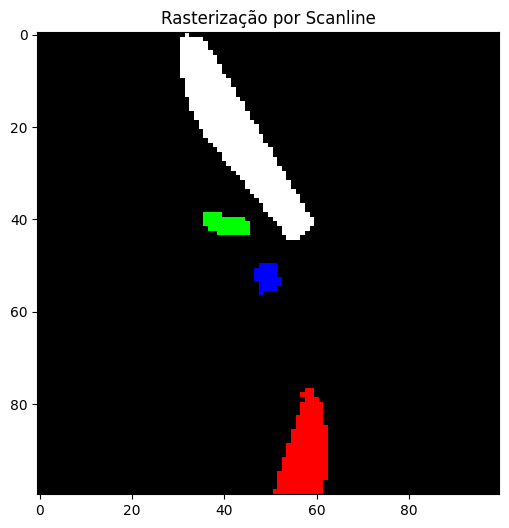

In [ ]:
#Rasteriza a cena, mas rasteriza o espaço que está normalizado, ou seja, tudo que está entre -1 e 1
#Transforma o o plano normalizado no plano da tela
def ndc_to_screen(ndc_vertex, width, height):
    x_screen = (ndc_vertex[0] + 1) * width / 2
    y_screen = (1 - ndc_vertex[1]) * height / 2
    return (x_screen, y_screen)

#Interpolação ao longo da aresta para gerar (x, y) por scanline.
def edge_interp(xa, ya, xb, yb):
    if int(ya) == int(yb):
        return []
    if ya > yb:
        xa, ya, xb, yb = xb, yb, xa, ya  # garante ya < yb
    x_vals = []
    for y in range(int(np.ceil(ya)), int(np.floor(yb)) + 1):
        t = (y - ya) / (yb - ya)
        x = xa + t * (xb - xa)
        x_vals.append((x, y))
    return x_vals

#rasteriza as faces trianguladas usando o scanline
def rasterize_triangle_scanline_screen(v0, v1, v2, color, image):
    height, width, _ = image.shape

    # Ordenar por Y (v0 é o mais alto, v2 o mais baixo)
    verts = sorted([v0, v1, v2], key=lambda v: v[1])
    x0, y0 = verts[0]
    x1, y1 = verts[1]
    x2, y2 = verts[2]

    # Lados
    full_edge = edge_interp(x0, y0, x2, y2)
    left_edge = edge_interp(x0, y0, x1, y1) + edge_interp(x1, y1, x2, y2)

    if len(full_edge) != len(left_edge):
        min_len = min(len(full_edge), len(left_edge))
        full_edge = full_edge[:min_len]
        left_edge = left_edge[:min_len]

    for i in range(len(full_edge)):
        y = int(full_edge[i][1])
        if 0 <= y < height:
            x_start = int(min(full_edge[i][0], left_edge[i][0]))
            x_end = int(max(full_edge[i][0], left_edge[i][0]))

            x_start = max(0, x_start)
            x_end = min(width - 1, x_end)
            image[y, x_start:x_end + 1] = color

# Parametros da rasterizaçaõ
width, height = 100, 100
image = np.zeros((height, width, 3), dtype=np.uint8)

# Solidos já projetados
objetos_ndc_para_rasterizar = [
    {"vertices_ndc": vertices_projetados_ndc_para, "faces": faces_para, "color": (0, 0, 255)},   # azul
    {"vertices_ndc": vertices_projetados_ndc_canoc, "faces": faces_canoc, "color": (255, 0, 0)}, # vermelho
    {"vertices_ndc": vertices_projetados_ndc_canor, "faces": faces_canor, "color": (255, 255, 255)}, # branco
    {"vertices_ndc": vertices_projetados_ndc_cilindro, "faces": faces_cilindro, "color": (0, 255, 0)} # verde
]

#Rasterização
for obj in objetos_ndc_para_rasterizar:
    vertices_ndc = obj["vertices_ndc"]
    faces = obj["faces"]
    color = obj["color"]

    for face in faces:
        v0_idx, v1_idx, v2_idx = face
        v0_ndc = vertices_ndc[v0_idx]/10
        v1_ndc = vertices_ndc[v1_idx]/10
        v2_ndc = vertices_ndc[v2_idx]/10

        # Converte para coordenadas de tela
        v0_screen = ndc_to_screen(v0_ndc, width, height)
        v1_screen = ndc_to_screen(v1_ndc, width, height)
        v2_screen = ndc_to_screen(v2_ndc, width, height)

        # Rasteriza triângulo
        rasterize_triangle_scanline_screen(v0_screen, v1_screen, v2_screen, color, image)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title("Rasterização por Scanline")
plt.axis('on')
plt.show()
